## Explains, visualizes, and analyses the ePodium dataset.

#### Import Packages

In [1]:
import mne
import pandas as pd
import numpy as np
import os
import glob
import copy
import sys

import PATH

from functions import display_helper
from functions import dataset_loading
from functions import epodium

#### Loading EEG-data and metadata

In [2]:
dataset_raw, dataset_filenames = dataset_loading.load_dataset(PATH.ePod_dataset, preload=False)

epodium_metadata_filenames = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
epod_children, epod_cdi, epod_parents, epod_codes = \
    dataset_loading.load_metadata(PATH.ePod_metadata, epodium_metadata_filenames)

206 EEG files loaded


#### Load events
+ Events are stored and loaded externally from a text file, since loading events from raw EEG file takes much longer. 
+ Set save_events_to_txt_file to true if the event markers are not yet on your disk. This will take a while. The text files are only ~4MB.

+ Information from each event can be printed given the participant and event index.

The events for four conditions are plotted from a single experiment. The events are combined so the different pronounciations or 'tokens' are not individually marked. This reduces the unique events from 78 to 12 distinct events. The pronounciations are called tokens.
+ Condition 1 GiepMT: standard "giep" - deviant "gip": multiple tokens 
+ Condition 2 GiepST: standard "giep" - deviant "gip": single token 
+ Condition 3 GopMT: standard "gop" - deviant "goep": multiple tokens 
+ Condition 4 GopST: standard "gop" - deviant "goep": single tokens

206 Event Marker files loaded
Participant 5 heard event ID: 15 after 390.6 seconds as event 500.


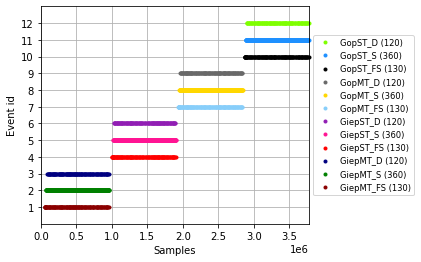

In [3]:
save_events_to_txt_file = False
if(save_events_to_txt_file):
    dataset_loading.save_events(PATH.ePod_events, dataset_raw, dataset_filenames)    
events = dataset_loading.load_events(PATH.ePod_events, dataset_filenames)

dataset_loading.print_event_info(events, participant_index = 5, event_index = 500)

events_12 = epodium.group_events_12(events)
fig = mne.viz.plot_events(events_12[4], event_id = epodium.event_dictionary, 
                          color = display_helper.color_dictionary)

#### Show data fragment of ePOD dataset

Using matplotlib as 2D backend.
Opening raw-browser...


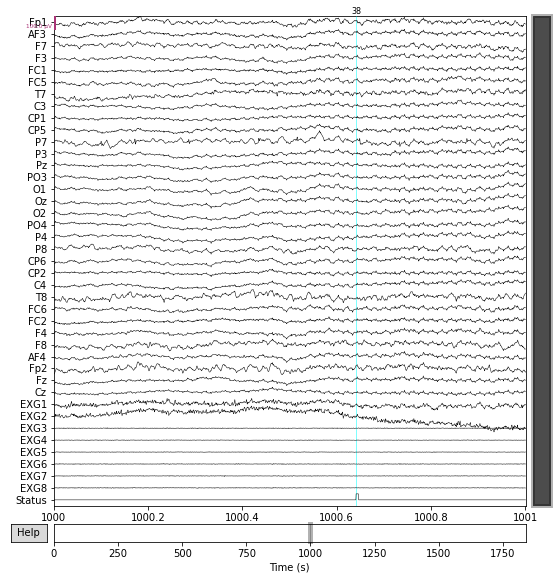

In [4]:
participant_index = 190
# channel_index = 4
# display_helper.show_raw_fragment(dataset_raw[participant_index], channel_index, 10,1)
fig = mne.viz.plot_raw(dataset_raw[participant_index], events[participant_index], n_channels=70, scalings = 50e-6  ,duration = 1, start = 1000)

In [5]:
#dataset_raw[participant_index].ch_names
epodium.DDP

'/volume-ceph/DDP_projectfolder'